<a href="https://colab.research.google.com/github/panoptes/afas-2024/blob/main/notebooks/PANOPTES%20Stack%20Observation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

This will install the [`panoptes-data`](https://github.com/panoptes/panoptes-data) module, which contains a number of useful features for working with images.

It might take a moment to run this cell while the required libraries are installed.

In [1]:
%%capture
%pip install panoptes-data

In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
import requests
from tqdm.auto import tqdm
from astropy.visualization import simple_norm
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D, CCDData

from google.colab import data_table

from panoptes.data.search import get_all_observations
from panoptes.data.observations import ObservationInfo

data_table.enable_dataframe_formatter()

# Stack observation images

In this notebook we will search for a given observation and then make some simple image stacks of the data.

## Search for field

Get a list of all of the available fields and show the ones with the most observations.

In [3]:
# Download a CSV list of all the available observations.
search_results = get_all_observations()

In [4]:
# Show the top ten fields with the most observations.
search_results.field_name.value_counts().reset_index()

,field_name,count
0,FU Orionis,277
1,KIC 8462852,266
2,TESS_SEC17_CAM02,255
3,TESS_SEC23_CAM03,246
4,TESS_SEC06_CAM01,161
...,...,...
195,Alnilam,1
196,HAT-P-14,1
197,PICID 41330864,1
198,TESS_SEC21_CAM04,1


In [5]:
# Pick a field and get the coordinates.
field_name = 'M42'

search_coords = SkyCoord.from_name(field_name)
search_coords

<SkyCoord (ICRS): (ra, dec) in deg
    (83.82, -5.39)>

## Select observation

A `sequence_id` is used to explore observations. Here we get the most observation to get the `sequence_id`.

In [6]:
# We choose an entry that only has a few images while running on binder and get the most recent.

record = search_results.query('field_name == @field_name').sort_values(by='num_images').iloc[-1]
record.T

time                                     2022-01-15 08:21:08+00:00
num_images                                                   104.0
software_version             POCSv0.8.0.post0.dev7+g8c57c125.dirty
sequence_id                          PAN019_42433a_20220115T082108
image_type                                                 SCIENCE
unit_id                                                     PAN019
imagew                                                      6020.0
total_exptime                                               9361.0
field_name                                                     M42
imageh                                                      4016.0
camera_camera_id                                            42433a
camera_lens_serial_number                                RL1548256
camera_serial_number                                  273074013260
coordinates_mount_ha                                      0.794656
coordinates_mount_dec                                     -5.3

In [7]:
sequence_id = record.sequence_id
sequence_id = 'PAN019_c623e9_20220115T082108'

## Get Observation info

We can get more information about the observation by creating an `ObservationInfo` object. You can create it with just a `sequence_id` (e.g. `ObservationInfo(sequence_id=record.sequence_id)) but here we pass all the meta data.

In [8]:
obs_info = ObservationInfo(sequence_id)

We can do a simple check for the quality of our data by checking the median detected FWHM for all the images in the observation:

In [9]:
obs_info.get_metadata().status.value_counts()

status
MATCHED    105
Name: count, dtype: int64

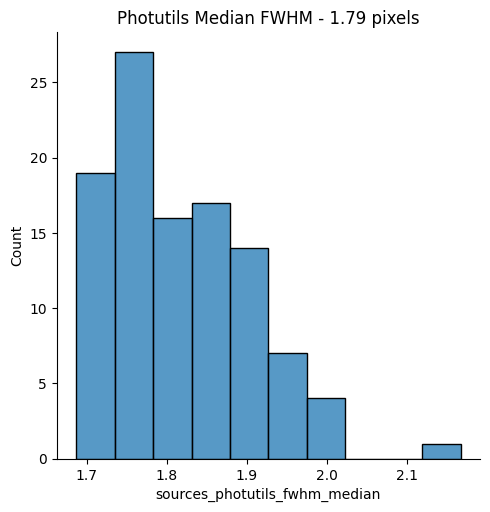

In [10]:
fg = sb.displot(obs_info.image_metadata.sources_photutils_fwhm_median)
fg.ax.set_title(f'Photutils Median FWHM - {obs_info.image_metadata.sources_photutils_fwhm_median.median():.02f} pixels');

## Plot a single image

We can retrieve the data for the image by using the `get_image_data` function using the index of the image from the `raw_images` list.

An optional `coords` and `box_size` allow for cropping of the data as it is returned (the full data still travels over the network as of now).

You can also retrieve the raw or processed data using the `use_raw=True` flag.

In [11]:
cutout_size = (250, 250)

In [12]:
obs_info.image_list = obs_info.image_metadata.public_url.to_list()

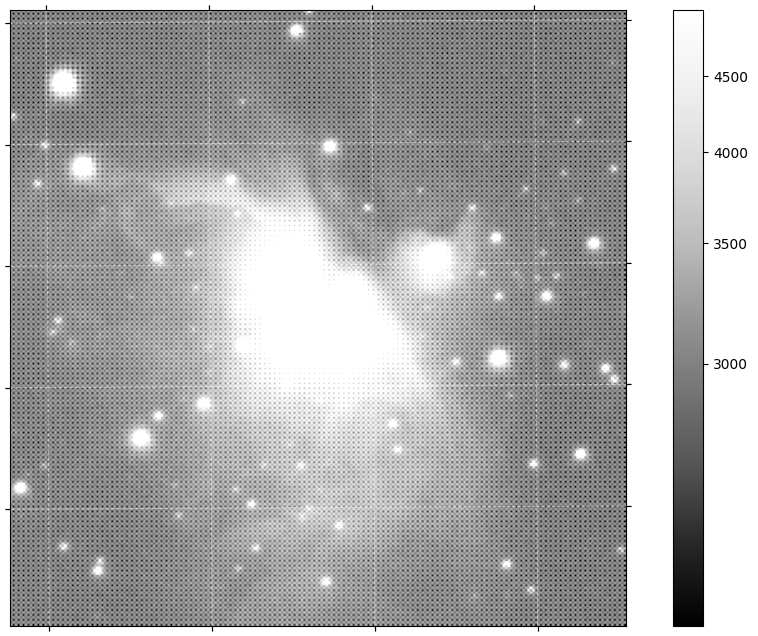

In [13]:
data0 = obs_info.get_image_data(idx=0)
cutout0 = obs_info.get_image_cutout(data=data0, coords=search_coords, box_size=cutout_size)

ax = plt.subplot(projection=cutout0.wcs)

norm = simple_norm(cutout0.data, 'sqrt', min_percent=5, max_percent=94)

im = ax.imshow(cutout0.data, origin='lower', norm=norm, cmap='Greys_r')
ax.figure.colorbar(im, ax=ax)
ax.figure.set_size_inches(12, 8)

ax.grid(color='white', ls='--', alpha=0.5);

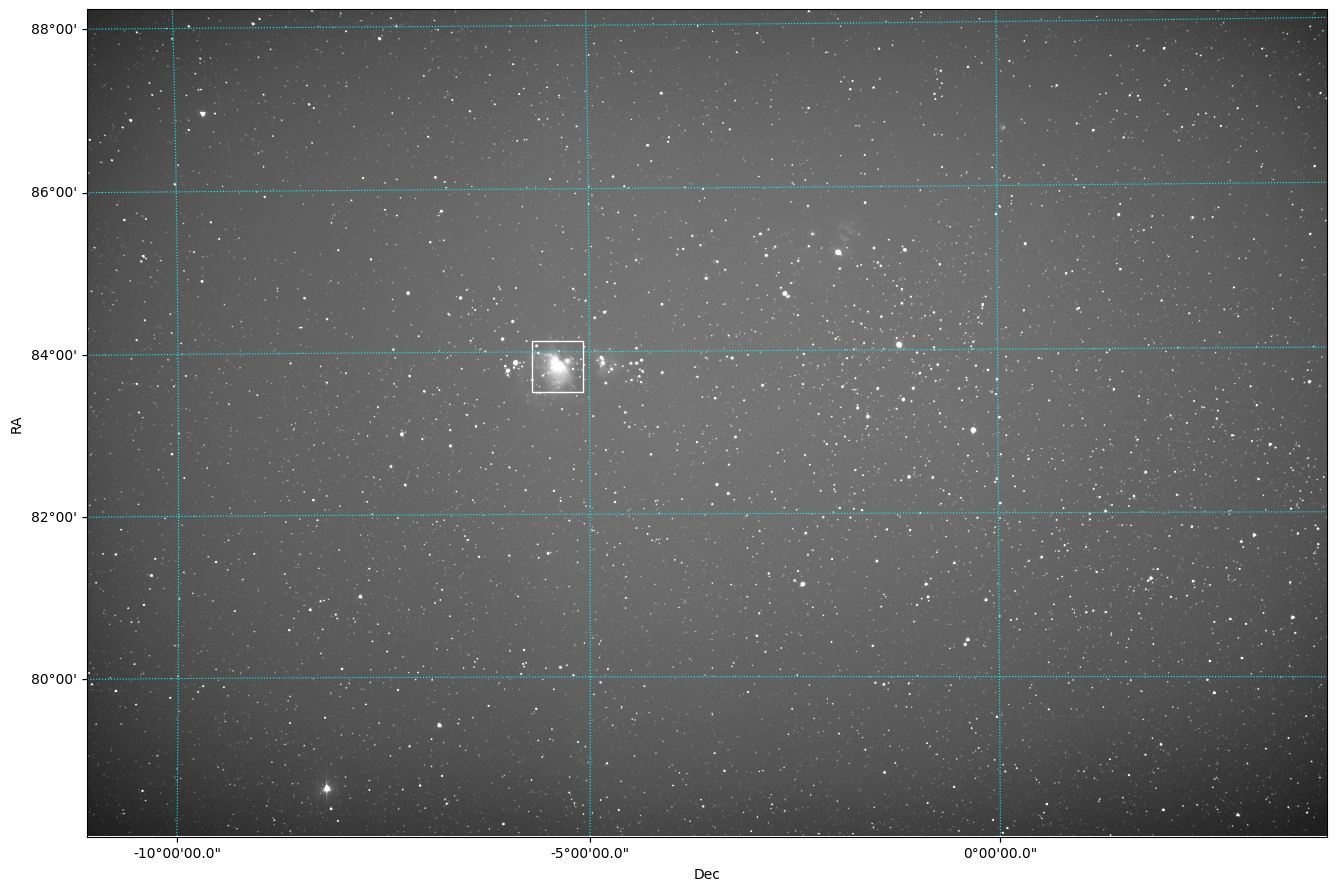

In [14]:
# Plot on the original.
ax = plt.subplot(projection=data0.wcs)

norm = simple_norm(data0.data, 'asinh', min_percent=10, max_percent=99.9)
ax.imshow(data0.data, origin='lower', norm=norm, cmap='Greys_r')
cutout0.plot_on_original(color='white')

ax.grid(color='cyan', ls='dotted')

# Show equatorial grid.
ra = ax.coords[0]
ra.set_major_formatter('dd:mm')
ra.set_ticks_position('l')
ra.set_ticklabel_position('l')
ra.set_axislabel_position('l')
ra.set_axislabel('RA')

dec = ax.coords[1]
dec.set_major_formatter('dd:mm:ss.s')
dec.set_ticks_position('b')
dec.set_ticklabel_position('b')
dec.set_axislabel_position('b')
dec.set_axislabel('Dec')


ax.figure.set_size_inches(16, 12)

We can perform this action in a loop to retrieve the same cutout for all the images in the observation.

Below we fetch the data for all the images into a list and then plot a single frame (similar to above), a median stack, and summation of all the data.

## Stack images

Here we grab cutoutouts centered around our `search_coords` for all the images in this observation.

In [15]:
stack_cutout = list()
for i, img in tqdm(enumerate(obs_info.image_list), total=len(obs_info.image_list), desc='Fetching image cutouts'):
    try:
        cutout_data = obs_info.get_image_cutout(idx=i, coords=search_coords, box_size=cutout_size).data
        stack_cutout.append(cutout_data)
    except Exception:
        # Skip some that have errors.
        pass

stack_cutout = np.array(stack_cutout)

Fetching image cutouts:   0%|          | 0/105 [00:00<?, ?it/s]

We then make some simple plots of the data in various ways: a single frame, the difference image for the observation, a median stack, and a full co-add.

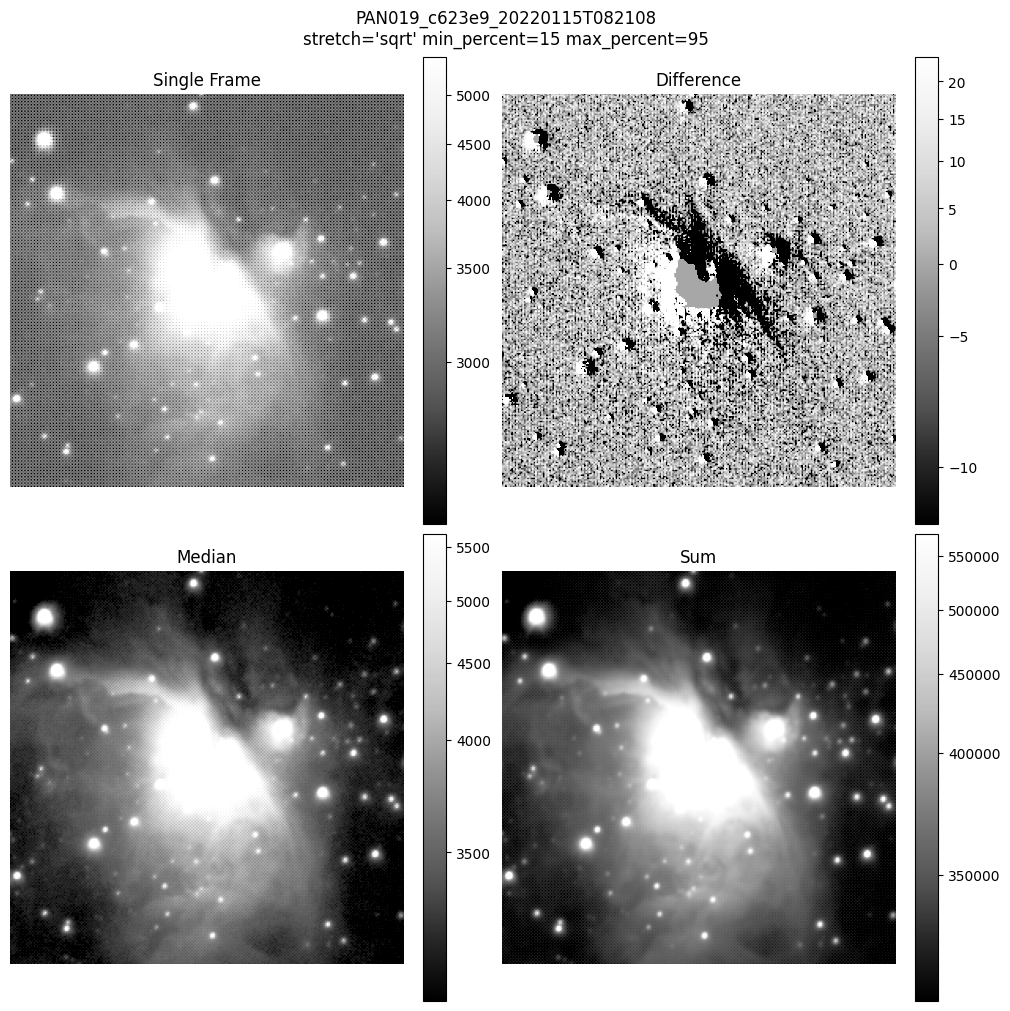

In [16]:
stretch = 'sqrt' # asinh, power, log, linear
min_percent = 15
max_percent = 95

fig, axes = plt.subplots(ncols=2, nrows=2, layout='constrained')

# Make a difference image.
diffs = pd.DataFrame(stack_cutout.reshape(stack_cutout.shape[0], -1).astype('float'))
diffs = diffs.diff().values.reshape(stack_cutout.shape[0], *cutout_size)[1:]

# Show different types of plots.
types = {
    'Single Frame': stack_cutout[0],
    'Difference': np.median(diffs, 0),
    'Median': np.median(stack_cutout, 0),
    'Sum': stack_cutout.sum(0),
}

# Create each plot type.
for i, (title, data) in enumerate(types.items()):
    norm = simple_norm(data, stretch, min_percent=min_percent, max_percent=max_percent)

    ax = axes.flatten()[i]
    im = ax.imshow(data, norm=norm, origin='lower', cmap='Greys_r')
    fig.colorbar(im, ax=ax)
    fig.suptitle(
        f'{sequence_id}\n'
        f'{stretch=} {min_percent=} {max_percent=}'
    )
    ax.set_title(title)
    ax.axis('off')

fig.set_dpi(100)
fig.set_size_inches(10, 10)